In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
import operator

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import pandas_bokeh
from bokeh.io import output_notebook, show
from bokeh.resources import INLINE
from bokeh.plotting import figure
output_notebook(INLINE)

# pandas_bokeh.output_notebook()
from geopy.distance import great_circle
import gc, os, sys, pickle, random, time, cmath, re
import geopy
from collections import Counter, defaultdict
from functools import partial
from pathlib import Path

from contextlib import contextmanager
import multiprocessing
import shap

from datetime import datetime
# import librosa
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit, KFold
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.mixture import BayesianGaussianMixture
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import RandomizedSearchCV

from sklearn.neighbors import KNeighborsClassifier 
from sklearn.cluster import KMeans
from lightgbm import LGBMClassifier, LGBMRegressor
from category_encoders import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

Loading BokehJS ...

In [2]:
def load_df(dataset):
    if 'train' in dataset:
        df = pd.read_csv("../data/{}.csv".format(dataset))
    elif 'test' in dataset:
        df = pd.read_csv("../data/{}.csv".format(dataset))
    return df

print('Download Train and Test Data.\n')
with multiprocessing.Pool() as pool: 
    train, test = pool.map(load_df, ["train", "test"])

def land_outlier_Bayesian(train, test):
    
    combine = pd.concat([train, test])
    
    for i in combine.columns:
        combine[i].replace([np.inf, -np.inf], np.nan, inplace=True)
    cols = combine.columns[~combine.isna().any()].tolist()
    # non - NaN columns 
    
    cols = [e for e in cols if e not in ('total_price', 'building_id','area_ratio',
                                                 'txn_dt','land_area', 'building_area')]
    try:
        nan_cols.remove('land_area')
    except:pass
    y = combine[combine['land_area']!=0]['land_area']
    model = BayesianRidge(normalize=True)
    model.fit(combine[combine['land_area']!=0][cols], y)

    result = model.predict(combine[combine['land_area']==0][cols])
    combine.loc[combine['land_area']==0,'land_area'] = result

    train = combine[combine['total_price'].notnull()]
    test = combine[combine['total_price'].isnull()]
    del combine; gc.collect()
    
    return train, test

def land_outlier_correction(train, test):
    
    train.loc[(train['land_area']==0)&(train['XIV_10000']==14502)
              &(train['building_complete_dt']==8190),'land_area']=9.642834

    train.loc[(train['land_area']==0)&(train['building_complete_dt']==10228),
                  'land_area'] = 44.889814
    train.loc[(train['land_area']==0)&(train['building_complete_dt']==11020)&
              (train['village']==1888),'land_area'] = 13.106
    train.loc[(train['land_area']==0)&(train['lon']==119.32)&(train['lat']==-37.7)&
              (train['building_complete_dt']==11416),'land_area']= 2.222

    test.loc[(test['land_area']==0)&(test['XIV_5000']==11882)&
             (test['total_floor']==10),'land_area']= 2.222

    test.loc[(test['land_area']==0)&(test['lon']==119.37)&(test['lat']==-37.66)&
         (test['building_complete_dt']==6606),'land_area']= 2.222

    test.loc[(test['land_area']==0)&(test['lon']==119.32)&
             (test['lat']==-37.72),'land_area'] = 13.106
    
    
    return train, test


def city_median_transform(train, test):

    train['city'] = train['city'].map({3:'Keelung',13:'Taipei', 7:'NewTaipei', 10:'TaoYuan', 9:'Hsinchu', 
                                       17:'Miaoli', 12:'Taichung', 6:'Changhua', 14:'Tainan', 21:'Kaohsiung', 5:'Pingtung'})
    test['city'] = test['city'].map({3:'Keelung',13:'Taipei', 7:'NewTaipei', 10:'TaoYuan', 9:'Hsinchu', 
                                       17:'Miaoli', 12:'Taichung', 6:'Changhua', 14:'Tainan', 21:'Kaohsiung', 5:'Pingtung'})

    median_price = {'Changhua': 1.091, 'Hsinchu': 2.9586,
     'Kaohsiung': 0.968,'Keelung': 0.334,
     'Miaoli': 0.9681, 'NewTaipei': 4.276,
     'Pingtung': 0.0001,'Taichung': 2.334,
     'Tainan': 1.20641,'Taipei': 11.51634,
     'TaoYuan': 1.6873}
    
    train['city'] = train['city'].map(median_price)
    test['city'] = test['city'].map(median_price)
    
    return train, test

def feature_engineer(df):
    
    df['floor_2_top'] = df['total_floor'] -  df['txn_floor']
    df['area_ratio'] = df['building_area']/df['land_area'] # Very Powerful
#     df['area_diff'] = df['building_area'] - df['land_area'] 
    
    df['XIII_diff'] = df['XIII_10000'] - df['XIII_5000']
    df['XIII_diff_4_3'] = df['XIII_10000'] - df['XIII_1000']
    df['XIII_diff_3_2'] = df['XIII_1000'] - df['XIII_500']

    return df


# 中位數房價 高低：
# ['Taipei', 'NewTaipei', 'Hsinchu', 'Taichung', 'TaoYuan', 'Tainan',
#'Changhua', 'Miaoli', 'Kaohsiung', 'Keelung', 'Pingtung']


# train['PubPlace_each_floor'] = train['area_diff']/train['total_floor']
# test['PubPlace_each_floor'] = test['area_diff']/test['total_floor']

# train['logit_build_trade_diff'] = 1/(1+np.exp(-(train['txn_dt'] - train['building_complete_dt'])/train['txn_dt']) ) 
# test['logit_build_trade_diff'] = 1/(1+np.exp(-(test['txn_dt'] - test['building_complete_dt'])/test['txn_dt']) )
def median_income_rulebase(train, test):
    combine = pd.concat([train, test])
    del train, test;
    gc.collect()
    collection = list(combine[combine['village_income_median'].isnull()]['lonlat'].unique())
    for i in collection:
        if combine[combine['lonlat']==i]['village'].nunique()!=1:

            if combine[combine['lonlat']==i]['village_income_median'].std() <=50:
                combine.loc[(combine['village_income_median'].isnull())&(combine['lonlat']==i), 
                            'village_income_median'] = combine[combine['lonlat']==i]['village_income_median'].mean()
    train = combine[combine['total_price'].notnull()]
    test = combine[combine['total_price'].isnull()]
    del combine;
    return train, test
combine = pd.concat([train, test])
target = train['total_price']


Download Train and Test Data.



# 經緯度轉換

In [3]:
def coordinate_transform(train, test):
        #(118.95, -37.46)
    X1 = np.matrix([(117.2,-40.01), (119.66,-37.75), (118.95, -37.46)]) #(118.02,-37.93)])
    X2 = np.matrix([(120.713287,21.987057), (121.775596, 25.142056), (120.499489, 24.214840)])
    T = inv(X1.T * X1) * X1.T * X2
    coor_trans_trn = np.matrix(train[['lon', 'lat']])*T
    coor_trans_sub = np.matrix(test[['lon', 'lat']])*T
    train['lon'] = np.array(coor_trans_trn[:,0]).squeeze()
    train['lat'] = np.array(coor_trans_trn[:,1]).squeeze()

    test['lon'] = np.array(coor_trans_sub[:,0]).squeeze()
    test['lat'] = np.array(coor_trans_sub[:,1]).squeeze()
    return train, test
# train, test = coordinate_transform(train, test)

# Cluster Target Encode

In [4]:
class cluster_target_encoder:
    def __init__(self, nclusters = 3, seed=0, njobs = -1):
        self.seed = seed
        self.nclusters = nclusters
        self.njobs = njobs
    def make_encoding(self,df):
        self.encoding = df.groupby('X')['y'].mean()
        
    def fit(self,X,y):
        df = pd.DataFrame(columns=['X','y'], index=X.index)
        df['X'] = X
        df['y'] = y
        self.make_encoding(df)
        clust = KMeans(self.nclusters, random_state=self.seed, max_iter = 2000, n_jobs = self.njobs)
        labels = clust.fit_predict(self.encoding[df['X'].values].values.reshape(-1,1))
        df['labels'] = labels
        self.clust_encoding = df.groupby('X')['labels'].median()
        
    def transform(self,X):
        res = X.map(self.clust_encoding).astype(float)
        return res
    def fit_transform(self,X,y):
        self.fit(X,y)
        return self.transform(X)

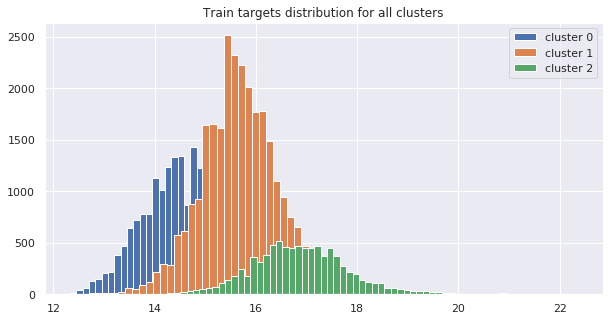

In [5]:
train['lonlat'] = train['lon'].apply(lambda x: str((int(x*100)))) + train['lat'].apply(lambda x: str((int(x*-100))))
test['lonlat'] = test['lon'].apply(lambda x: str((int(x*100)))) + test['lat'].apply(lambda x: str((int(x*-100))))

cate = 'lonlat'

X_train = train.drop(['total_price'],axis=1)
y_train = np.log1p(train['total_price'])

encoder = cluster_target_encoder(nclusters=3, seed=2019, njobs = -1)
labels_train = encoder.fit_transform(X_train[cate], y_train)
labels_test = encoder.transform(test[cate])

est = LGBMClassifier()

est.fit(X_train.select_dtypes(include=[np.number]),labels_train)

labels_test[np.isnan(labels_test)] = est.predict(
    test.select_dtypes(include=[np.number]))[np.isnan(labels_test)]

train['labels'] = labels_train
test['labels'] = labels_test
re_map = { 0:1, 1:0, 2:2}

train['labels'] = train['labels'].map(re_map)
test['labels'] = test['labels'].map(re_map)
plt.figure(figsize=(10,5))
plt.hist(y_train.values[train['labels']==0],bins=70,label='cluster 0')
plt.hist(y_train.values[train['labels']==1],bins=70,label='cluster 1')
plt.hist(y_train.values[train['labels']==2],bins=70,label='cluster 2')
# plt.hist(y_train.values[train['labels']==3],bins=70,label='cluster 3')
# plt.hist(y_train.values[train['labels']==4],bins=70,label='cluster 4')

plt.legend()
plt.title('Train targets distribution for all clusters')
# plt.xlim((10,22))
plt.show()

In [7]:
# labels_test[np.isnan(labels_test)].shape()
cross_val_score(
    X = X_train.select_dtypes(include=[np.number]),
    y = labels_train,
    estimator = LGBMClassifier(),
    cv = 5,
    scoring = 'roc_auc')

array([0.99884859, 0.99875134, 0.99974263, 0.99891858, 0.99983075])

In [6]:
train, test = land_outlier_correction(train, test)
train, test = land_outlier_Bayesian(train, test)
train, test = city_median_transform(train, test)
train, test = median_income_rulebase(train, test)

train = feature_engineer(train)
test = feature_engineer(test)

## Parking Recovery
- 'parking_way' 車位停放方式 // 3 
- 'parking_area' 車位面積
- 'parking_price'

Q: 驗證 具備停車面積，就一定有停車價位， vice versa.

What I Found:

Q: 需要買停車位的縣市，應該是大城市(cnt/%)
- [x]  新北，台北，桃園，台中，高雄，新竹 (cnt)
- [x]  新北，桃園，台北，新竹，台中，基隆 (%)

Q: No need 買停車位的縣市，應該是small城市 (cnt/%)
- [ ]  新北，台北，桃園，台中，高雄 (cnt)
- [x]  苗栗，屏東，台南，高雄，彰化 (%)

```python
D = {
3:'Keelung',13:'Taipei', 7:'NewTaipei', 10:'TaoYuan', 9:'Hsinchu', 
17:'Miaoli', 12:'Taichung', 6:'Changhua', 14:'Tainan', 21:'Kaohsiung', 
5:'Pingtung'}

Temp = {}
Ans = {}
for i in combine['city'].unique():
    Temp[i] = combine[(combine['parking_area'].isnull())&(combine['city']==i)].shape[0]    
    Temp[i]/= combine[combine['city']==i].shape[0]
    Ans[D[i]] = Temp[i]

sorted(Ans.items(), key=operator.itemgetter(1))
```

有停車面積，跟價位，不會具備 `parking_way = 2`
```
combine[combine['parking_price'].notnull()]['parking_way'].value_counts()
combine[combine['parking_area'].notnull()]['parking_way'].value_counts()
```
   - Hypothesis: 停車方式2 = 路邊停車？
       - [x] 停車方式2，高到低：屏東，苗栗，彰化，台南 (9) 
       


## Hypothesis Same Building ot not ?
- are these 1 floor sold out apartment or not ?
    - The price of these 1 floor in big city

- 交易樓層1，數量排行 by city
    1. Pt 2nd
    2. ML 1st
    3. 彰 5 (city)
    4. TP 4
    5. NewTP 4
    6. 中 7 (city)
    7. HC 7
    
- def 鄉下：屏東，台南，苗栗，彰化

### 一樓 ＶＳ 公寓， 
    1. 雙北，一樓中位數都高於，公寓
    2. 最低價都是一樓最高
    3. 最高價除了「台南，屏東」，其餘都是 「公寓」屌打「一樓」
    - 一樓都是屬於郊區？？？？
    - quantile(0.7) 可以看出房價差異大 台中台南
```python
for i in train['city'].unique(): 
    print(D[i],train[(train['txn_floor']==1)&(train['city']==i)]['total_price'].quantile(0.9))
    print(D[i],train[(train['txn_floor']!=1)&(train['city']==i)]['total_price'].quantile(0.9),'\n')

```
```python
3:'Keelung',13:'Taipei', 7:'NewTaipei', 10:'TaoYuan', 9:'Hsinchu', 
17:'Miaoli', 12:'Taichung', 6:'Changhua', 
14:'Tainan', 21:'Kaohsiung', 5:'Pingtung'```

## Village Income Median Recovery
- [X] 檢視直接補值可能性
- [X] 處理duplicat問題，1 village map multi town city

**Conclusion:** 沒可能

- [X] 檢視median income 與 何者最大關聯
    - LGB __txn_dt__, area_ratio, village, XII_Min, area_diff, VIII_Min, building_complete_dt

In [7]:
module_path = os.path.abspath(os.path.join('../model/'))

if module_path not in sys.path:
    sys.path.append(module_path)
from faster_check import fast_clf_verification, fast_reg_verification, display_importances

drop_list = train.select_dtypes(exclude=[np.number]).columns + ['total_price']
fast_reg_verification(train, test, 'village_income_median',  folds = 5)


## Recovery
- 要還原area

### What I Found
   - `building_complete_dt` 有無停車位 var 很大 1 order
   - `txn_dt` 沒這問題
```python
train[train['parking_area'].isnull()][['building_complete_dt','txn_dt']].var()
train[train['parking_area'].notnull()][['building_complete_dt','txn_dt']].var()
```
   - [Bayesian Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html#sklearn.linear_model.BayesianRidge)

## Completed Date 
- [ ] city 中位數屋齡

## Txn Year
- [x] city 中位數交易年，平均年
    - 幾乎雷同
    
## What I Found
    1. 從交易日，完工日的差距，可以知道，有資料是「事先買房」

In [55]:
# train['building_complete_dt'] = np.round(train['building_complete_dt']/365,2) - 48.62
# test['building_complete_dt'] = np.round(test['building_complete_dt']/365,2) - 48.62

# train['txn_dt'] = np.round(train['txn_dt']/365 ,2) - 48.62 # - 50
# test['txn_dt'] = np.round(test['txn_dt']/365 ,2) - 48.62

train['building_txn_diff'] = train['txn_dt'] - train['building_complete_dt'] 

test['building_txn_diff'] = test['txn_dt'] - test['building_complete_dt'] 

## Unit Area
   - WHAT I Found 
        1. 新北有outlier ,land_area=0
           - [ ] 處理 land_are outlie
           ```python
            train.loc[(train['land_area']==0)&(train['XIV_10000']==14502)
          &(train['building_complete_dt']==8190),'land_area']=9.642834

            train.loc[(train['land_area']==0)&(train['building_complete_dt']==10228),
                          'land_area'] = 44.889814
            train.loc[(train['land_area']==0)&(train['building_complete_dt']==11020)&
                      (train['village']==1888),'land_area'] = 13.106
            train.loc[(train['land_area']==0)&(train['lon']==119.32)&(train['lat']==-37.7)&
                      (train['building_complete_dt']==11416),'land_area']= 2.222

            test.loc[(test['land_area']==0)&(test['XIV_5000']==11882)&
                     (test['total_floor']==10),'land_area']= 2.222

            test.loc[(test['land_area']==0)&(test['lon']==119.37)&(test['lat']==-37.66)&
                 (test['building_complete_dt']==6606),'land_area']= 2.222

            test.loc[(test['land_area']==0)&(test['lon']==119.32)&
                     (test['lat']==-37.72),'land_price'] = 13.106
           ```

In [51]:
# combine[combine.isin([ np.nan, np.inf, -np.inf])].columns
# combine.columns[combine.isin([ np.nan, np.inf, -np.inf])].tolist()

In [ ]:
dt_today = datetime.today()

def display_shapley_values(feat_importance):
    best_features = feat_importance[["feature", "shap_values"]].groupby("feature")["shap_values"].agg(['mean', 'std']) \
                                                               .sort_values(by="mean", ascending=False).head(50).reset_index()
    best_features.columns = ["feature", "mean shapley values", "err"]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="mean shapley values", y="feature", xerr=best_features['err'], data=best_features)
    plt.title('LightGBM shapley values (avg over folds)')
    plt.savefig('shap_{}.png'.format(dt_today.strftime("%m_%d")))
    plt.tight_layout()
    plt.show()
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:50].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_{}.png'.format(dt_today.strftime("%m_%d")))
    
def hit_rate(y_true, y_pred):
    return np.mean(np.array([1 if i <= 0.1 else 0 for i in np.abs((y_pred - y_true)/y_true)]))

def Mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true)/y_true))

def score(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return (np.round(hit_rate(y_true, y_pred), 4)*1e4 + 1 - Mape(y_true, y_pred))

def model(trn, sub, folds, save):
    print('Official Metrics Test Score: ',score(np.array([1000,1000,1000]), np.array([1300,1100,1050])))
    trn_shape = trn.shape[0]
    print('Shape Trn {} Sub {}'.format(trn.shape, sub.shape))
    feats = [f for f in trn.columns if f not in ['building_id', 'total_price','lonlat','CTV']]
    combine = pd.concat([trn[feats], sub[feats]])
    
    average = 0
    for col in feats:
        average += np.array(combine[col].rank(ascending=1))
    average = average/len(feats)
    combine['AVERAGE'] = average
    feats = [f for f in trn.columns if f not in ['building_id', 'total_price','lonlat','CTV']]

    trn = combine.iloc[:trn_shape, :]
    sub = combine.iloc[trn_shape:, :]
    
    del combine; gc.collect()
    X = trn[feats]
    y = np.log1p(target)    
    
    sss = KFold(n_splits=folds, shuffle=True, random_state=0)
    feature_importance_df = pd.DataFrame()
    oof_preds = np.zeros(trn.shape[0])
    sub_preds = np.zeros(sub.shape[0])
    
    for fold_, (train_index, test_index) in enumerate(sss.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        clf = LGBMRegressor(n_estimators=100000,
#                             objective='fair',
                            learning_rate =  0.01,#0.003,
                            num_leaves=150,                
                            feature_fraction = 0.5, # sub_feature ([x]0.4), ([O]0.5)
                            bagging_fraction= 0.8, # subsample
#                             lambda_l2 = 0.1,
#                             bagging_freq = 5,
#                             min_data_in_leaf= 30,
#                             min_sum_hessian_in_leaf= 10,
#                             tree_learner='serial',
#                             boost_from_average='false',
#                             device_type='gpu',
#                             gpu_use_dp=True,
                            silent=-1,
                            verbose=-1,
                            n_jobs=-1)
        
        clf.fit(X_train, y_train, eval_set=[ (X_train, y_train),(X_test, y_test )], 
#                 eval_metric= 'mse', 
#                 categorical_feature  = ['city','town','village'],
                verbose= 6000, early_stopping_rounds= 2000)
        
        y_pred = np.expm1(clf.predict(X_test, num_iteration=clf.best_iteration_))
        print('Fold {}'.format(fold_ + 1), 'Hit-Rate plus MAPE: {}'.format(score(np.expm1(y_test), y_pred)),'\n')
        print('Fold {}'.format(fold_ + 1), 'Hit-Rate {}'.format(hit_rate(np.expm1(y_test), y_pred)),'\n')
        
        if save:
            print('Saving model fold {}'.format(fold_ + 1))
            filename = './pickle/Lgb_{}.sav'.format(fold_ + 1)
            pickle.dump(clf, open(filename, 'wb'))
            print('\n')

        oof_preds[test_index] = y_pred
        sub_preds += clf.predict(sub[feats], num_iteration=clf.best_iteration_) / sss.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
#         fold_importance_df["shap_values"] = abs(shap.TreeExplainer(clf).shap_values(X_test)[:,:sub[feats].shape[1]]).mean(axis=0).T
        fold_importance_df["fold"] = fold_+ 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        del X_train, X_test;
        gc.collect()
        
    print('Full Hit-Rate plus MAPE score: {}'.format(score(target, oof_preds),'\n'))

    display_importances(feature_importance_df)
#     display_shapley_values(feature_importance_df)
    return feature_importance_df, oof_preds, sub_preds


feature_importance_df, oof_preds, sub_preds = model(train , test, folds=12, save = False)

Official Metrics Test Score:  6667.85
Shape Trn (60000, 242) Sub (10000, 242)
Training until validation scores don't improve for 2000 rounds.
[6000]	training's l2: 0.00355183	valid_1's l2: 0.0342182
[12000]	training's l2: 0.00100118	valid_1's l2: 0.0338567


 - Fold 1 Hit-Rate plus MAPE: 5895.8752496042125 

 - Fold 2 Hit-Rate plus MAPE: 5843.8709186408705 

 - Fold 3 Hit-Rate plus MAPE: 5705.869178575696 

 - Fold 4 Hit-Rate plus MAPE: 5868.872619319689 

 - Fold 5 Hit-Rate plus MAPE: 5910.873049078534 

 - Fold 6 Hit-Rate plus MAPE: 5833.876909648886

 - Fold 7 Hit-Rate plus MAPE: 5820.876481647538 

 - Fold 8 Hit-Rate plus MAPE: 5878.870929574115 

 - Fold 9 Hit-Rate plus MAPE: 5682.870294367255 

 - Fold 10 Hit-Rate plus MAPE: 5855.876848152574 

Full Hit-Rate plus MAPE score: 5829.873247860937

In [8]:
print('Full Hit-Rate plus MAPE score: {}'.format(score(target, oof_preds),'\n'))

Full Hit-Rate plus MAPE score: 5836.873732652657


In [8]:
print('Full Hit-Rate plus MAPE score: {}'.format(score(target, oof_preds),'\n'))

Full Hit-Rate plus MAPE score: 5831.8728415577825


In [ ]:
5818.8729, 5828, 

In [14]:
import lightgbm as lgb
model_num = 1

file = open("Lgb_{}.sav".format(model_num ),'rb')
gbm = pickle.load(file)
graph = lgb.create_tree_digraph(gbm)
graph.render(view=True)

import lightgbm
model_num = 1
with open('./pickle/Lgb_{}.sav'.format(model_num ), 'rb') as file:
    gbm = pickle.load(file)
    
graph = lgb.create_tree_digraph(gbm)
graph.render(view=True)

# Error Analysis
    - 從統計看出 差異最大 std 來自於 real Max 被低估

In [6]:
def hit_rate_all(y_true, y_pred):
    return np.array([1 if i <= 0.1 else 0 for i in np.abs((y_pred - y_true)/y_true)])

train['hit_rate'] = hit_rate_all(target, oof_preds)
train['pred'] = oof_preds
train[train['hit_rate']==0].shape
train[train['hit_rate']==0].to_csv('error.csv', index=False)

In [7]:
train['city'] = train['city'].map( { 1.091:'Changhua',  2.9586:'Hsinchu',
                                  0.968:'Kaohsiung',0.334:'Keelung',
                                  0.9681:'Miaoli',  4.276:'NewTaipei',
                                  0:'Pingtung', 2.334:'Taichung',
                                  1.20641:'Tainan', 11.51634:'Taipei',
                                  1.6873:'TaoYuan'})
train[train['hit_rate']==0]['city'].value_counts()


NewTaipei    6597
Taipei       4153
Kaohsiung    3860
Taichung     3185
Tainan       2400
TaoYuan      2290
Pingtung      723
Miaoli        531
Hsinchu       483
Changhua      441
Keelung       386
Name: city, dtype: int64

In [8]:
train['city'].value_counts()

NewTaipei    19664
Taipei       10756
Kaohsiung     7964
Taichung      7264
Tainan        4704
TaoYuan       4676
Pingtung      1224
Hsinchu       1125
Miaoli         984
Changhua       826
Keelung        813
Name: city, dtype: int64